In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Load the prepared data
def load_data(filepath='employee_data_prepared_for_ml.csv'):
    """Load the prepared employee data."""
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    
    # Remove pay rate change features
    columns_to_drop = ['pay_rate_change', 'pay_rate_change_pct']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    
    print(f"Loaded {len(df)} records with {df['employee_id'].nunique()} unique employees")
    return df

# Exploratory Data Analysis
def perform_eda(df):
    """Perform exploratory data analysis."""
    print("\n=== Exploratory Data Analysis ===")
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(f"Number of records: {len(df)}")
    print(f"Number of unique employees: {df['employee_id'].nunique()}")
    print(f"Year range: {df['year'].min()} to {df['year'].max()}")
    
    # Feature distributions
    print("\nAnalyzing numeric features...")
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ['employee_id', 'year', 'first_year']]
    
    # Create distribution plots for key metrics
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_columns[:6], 1):  # Plot first 6 numeric columns
        plt.subplot(2, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
    plt.savefig('feature_distributions.png')
    print("Feature distribution plots saved to 'feature_distributions.png'")
    
    # Correlation analysis
    plt.figure(figsize=(12, 10))
    correlation = df[numeric_columns].corr()
    sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    print("Correlation matrix saved to 'correlation_matrix.png'")
    
    return numeric_columns

# Feature Selection
def select_features(df, target_column, numeric_columns, k=10):
    """Select the best k features for predicting the target."""
    print(f"\n=== Feature Selection for Predicting {target_column} ===")
    
    # Define columns to exclude
    exclude_cols = [
        'employee_id', 'year', 'first_year', 'department', 
        'Location', 'Supervisor', target_column
    ]
    
    # Get feature columns
    feature_cols = [col for col in numeric_columns if col not in exclude_cols]
    
    # Handle case where we have fewer features than k
    k = min(k, len(feature_cols))
    
    # Get feature matrix and target
    X = df[feature_cols]
    y = df[target_column]
    
    # Select features
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Top {k} features for predicting {target_column}:")
    
    # Print features with their scores
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False)
    print(scores.head(k).to_string(index=False))
    
    return selected_features

# Train-test split with time consideration
def prepare_training_data(df, target_column, selected_features, time_split=True):
    """Prepare training and testing data with optional time-based split."""
    print("\n=== Preparing Training and Testing Data ===")
    
    X = df[selected_features]
    y = df[target_column]
    
    if time_split and df['year'].nunique() > 1:
        # Use the most recent year as test set
        print("Using time-based train-test split...")
        max_year = df['year'].max()
        train_mask = df['year'] < max_year
        test_mask = df['year'] == max_year
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        print(f"Training data: {len(X_train)} records ({df['year'].min()} to {max_year-1})")
        print(f"Testing data: {len(X_test)} records (year {max_year})")
    else:
        # Use random 80/20 split
        print("Using random train-test split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print(f"Training data: {len(X_train)} records")
        print(f"Testing data: {len(X_test)} records")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

# Train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, selected_features, target_column):
    """Train multiple models and evaluate their performance."""
    print(f"\n=== Training Models to Predict {target_column} ===")
    
    # Define models to train
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    # Results dictionary
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Choose scaled or unscaled data based on model type
        if name in ['Random Forest', 'Gradient Boosting']:
            # Tree-based models don't require scaling
            X_train_use, X_test_use = X_train, X_test
        else:
            # Linear models benefit from scaling
            X_train_use, X_test_use = X_train_scaled, X_test_scaled
        
        # Train the model
        model.fit(X_train_use, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_use)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred
        }
        
        # For interpretable models, show feature importance
        if name in ['Random Forest', 'Gradient Boosting']:
            feature_importance = pd.DataFrame({
                'Feature': selected_features,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            print("\n  Feature Importance:")
            print(feature_importance.head(5).to_string(index=False))
            
            # Visualize feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance)
            plt.title(f'Feature Importance for {name}')
            plt.tight_layout()
            plt.savefig(f'{name.lower().replace(" ", "_")}_importance.png')
    
    # Compare model performance
    model_comparison = pd.DataFrame({
        'Model': list(results.keys()),
        'MAE': [results[m]['mae'] for m in results],
        'RMSE': [results[m]['rmse'] for m in results],
        'R²': [results[m]['r2'] for m in results]
    })
    
    print("\nModel Comparison:")
    print(model_comparison.sort_values('MAE').to_string(index=False))
    
    # Visualize model comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='R²', data=model_comparison)
    plt.title('Model Comparison - R² Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    print("Model comparison chart saved to 'model_comparison.png'")
    
    # Find best model based on MAE
    best_model_name = model_comparison.sort_values('MAE').iloc[0]['Model']
    best_model = results[best_model_name]['model']
    
    return best_model, results, model_comparison

# Fine-tune the best model
def fine_tune_model(best_model_name, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    """Fine-tune the best performing model with hyperparameter optimization."""
    print(f"\n=== Fine-tuning {best_model_name} ===")
    
    # Skip fine-tuning for simple models
    if best_model_name == 'Linear Regression':
        print("Linear Regression doesn't require hyperparameter tuning.")
        return None
    
    # Define parameter grids for different models
    param_grids = {
        'Ridge Regression': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
        },
        'Lasso Regression': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'max_iter': [1000, 2000, 3000],
            'selection': ['cyclic', 'random']
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5],
            'subsample': [0.8, 1.0]
        }
    }
    
    # Get the appropriate parameter grid
    if best_model_name not in param_grids:
        print(f"No parameter grid defined for {best_model_name}.")
        return None
    
    param_grid = param_grids[best_model_name]
    
    # Create the model instance
    if best_model_name == 'Ridge Regression':
        model = Ridge()
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
    elif best_model_name == 'Lasso Regression':
        model = Lasso()
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
    elif best_model_name == 'Random Forest':
        model = RandomForestRegressor(random_state=42)
        X_train_use, X_test_use = X_train, X_test
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingRegressor(random_state=42)
        X_train_use, X_test_use = X_train, X_test
    
    # Perform grid search
    print(f"Performing grid search with {len(param_grid)} parameters...")
    grid_search = GridSearchCV(
        model, param_grid, scoring='neg_mean_absolute_error',
        cv=5, n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X_train_use, y_train)
    
    # Print best parameters
    print(f"\nBest parameters: {grid_search.best_params_}")
    
    # Evaluate the model with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_use)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Fine-tuned model performance:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    
    return best_model




===== PREDICTING PAY RATE =====
Starting ML pipeline for predicting pay_rate
Loading data from employee_data_prepared_for_ml.csv...
Loaded 138 records with 45 unique employees

=== Exploratory Data Analysis ===

Basic Statistics:
Number of records: 138
Number of unique employees: 45
Year range: 2021 to 2024

Analyzing numeric features...
Feature distribution plots saved to 'feature_distributions.png'
Correlation matrix saved to 'correlation_matrix.png'

=== Feature Selection for Predicting pay_rate ===
Top 10 features for predicting pay_rate:
           Feature      Score
            tenure 192.820476
 previous_pay_rate  81.295985
       days_worked  77.423314
       total_hours  75.488939
     overtime_days   9.601928
department_encoded   2.254611
   max_daily_hours   2.128991
   min_daily_hours   1.637607
supervisor_encoded   1.427565
   std_daily_hours   1.020173

=== Preparing Training and Testing Data ===
Using time-based train-test split...
Training data: 93 records (2021 to 202

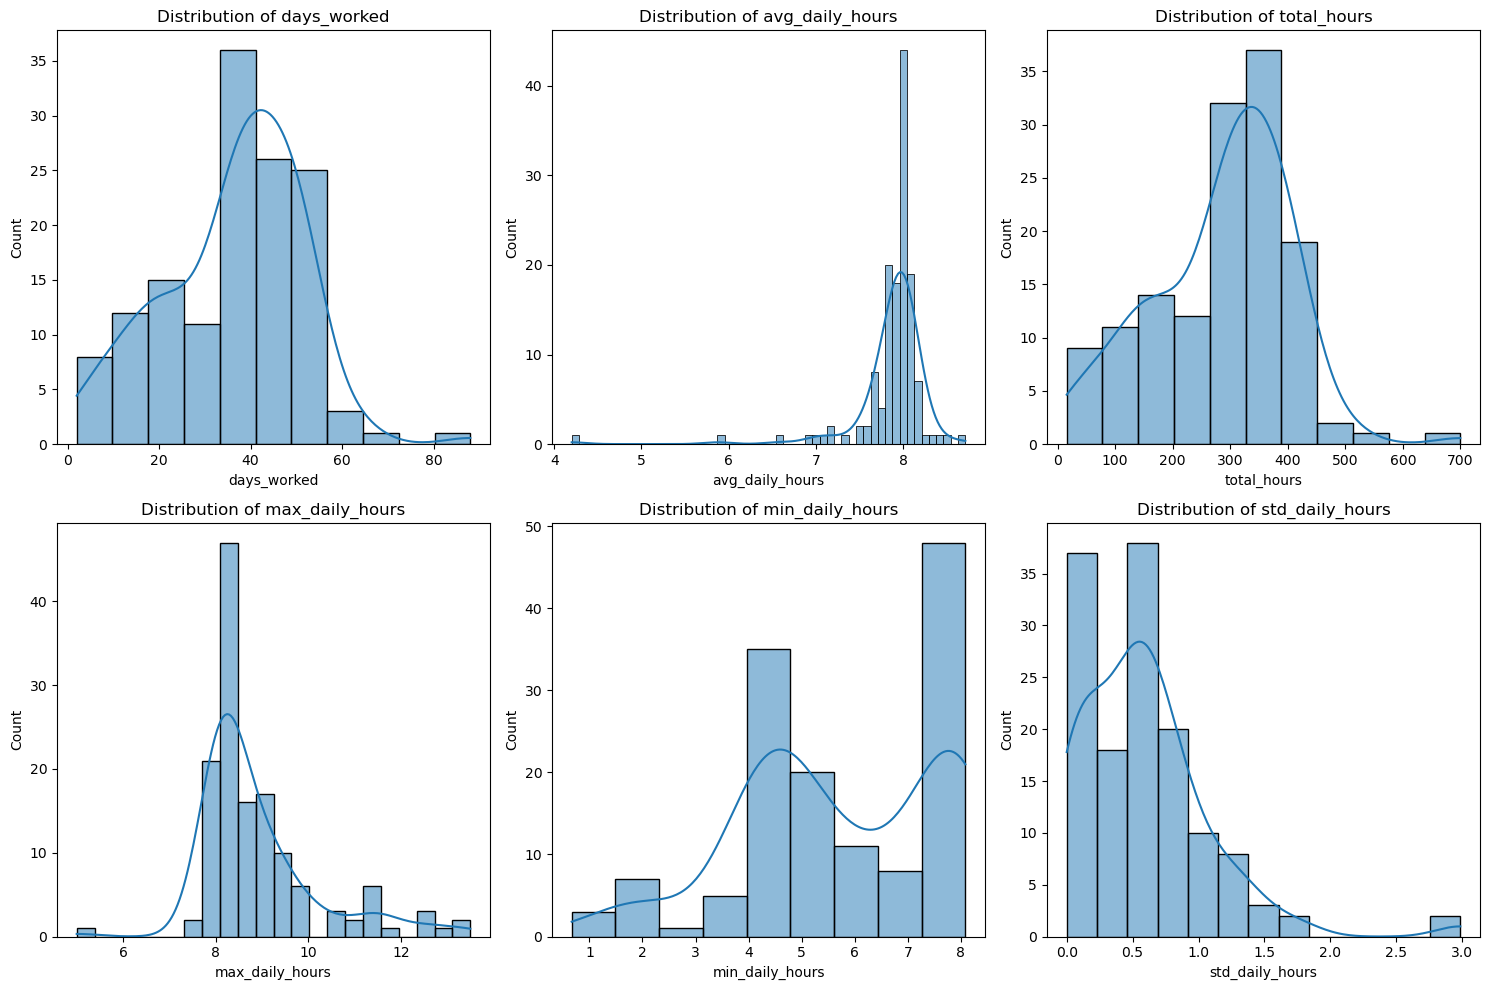

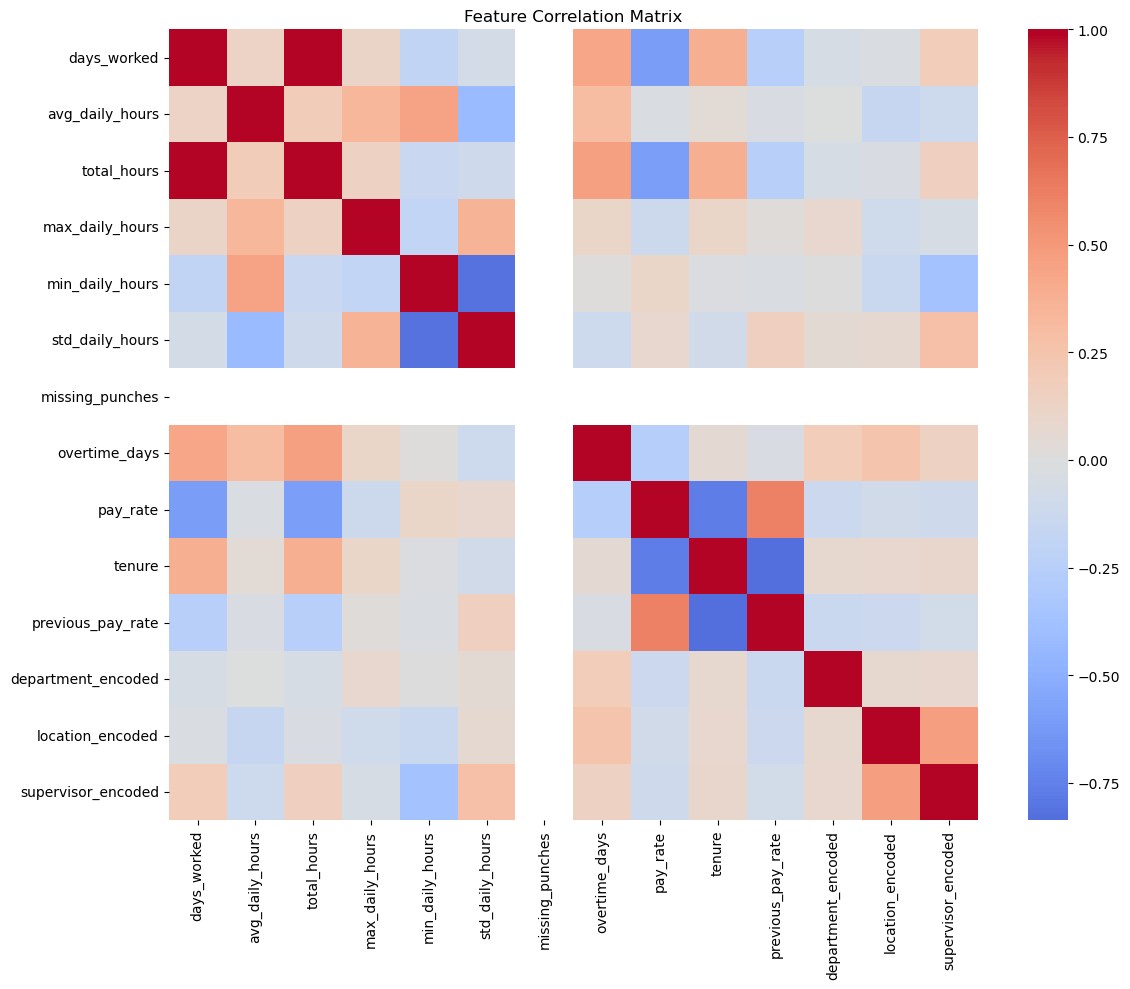

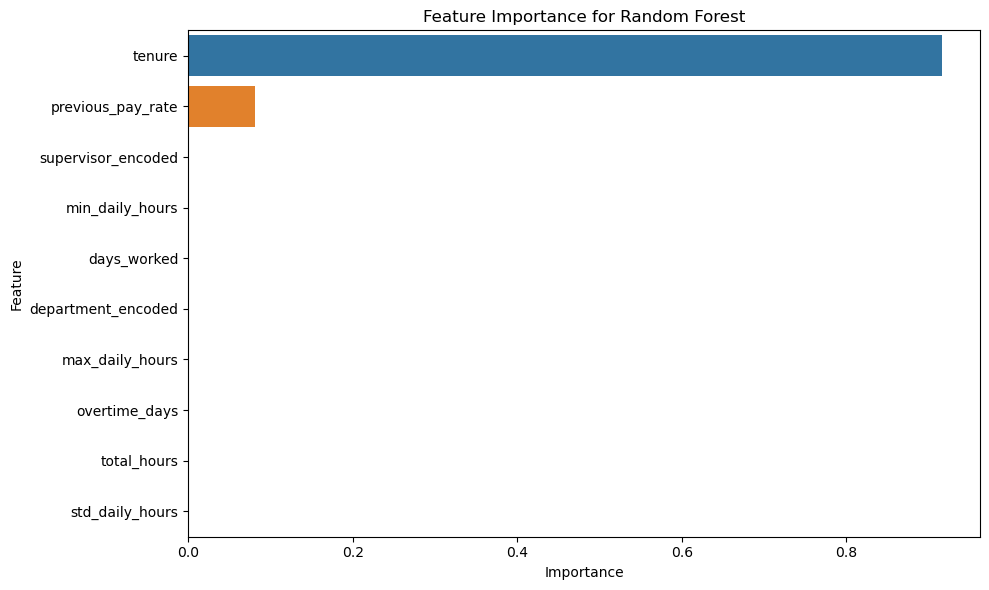

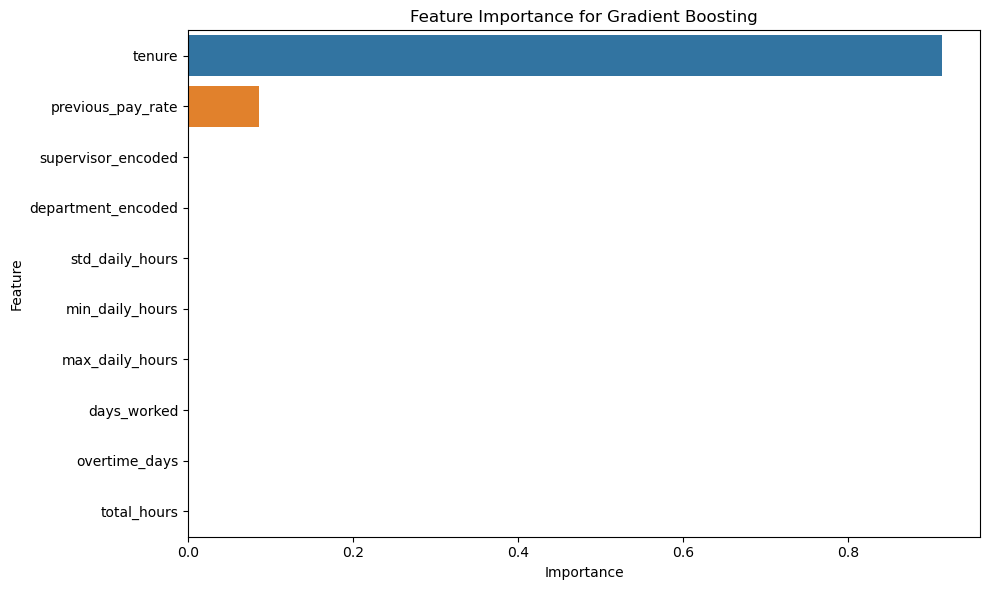

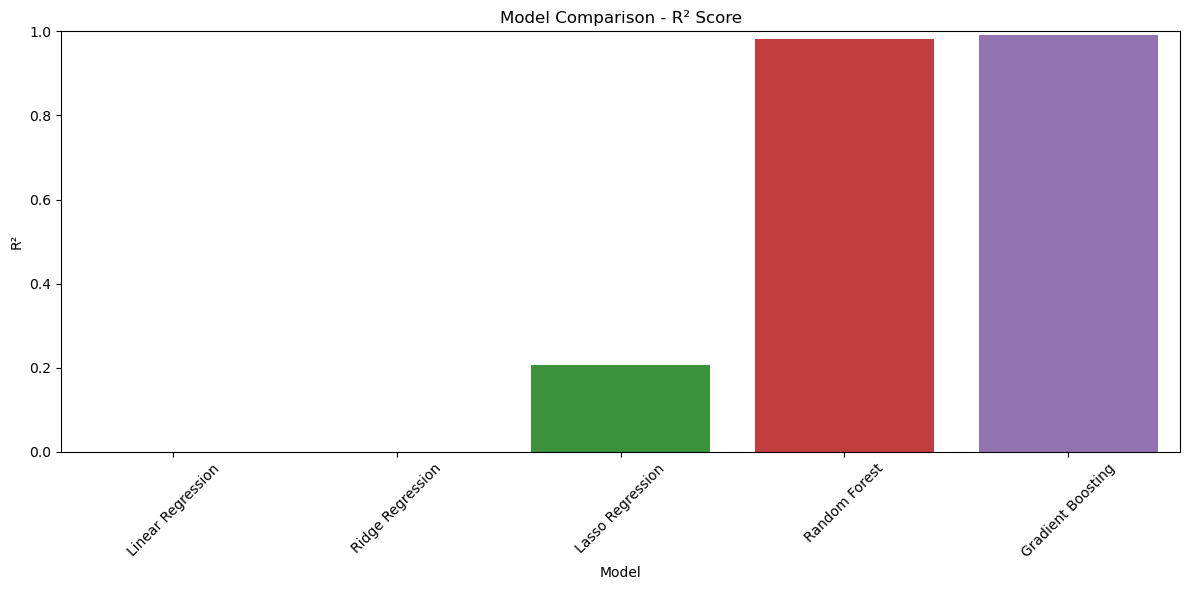

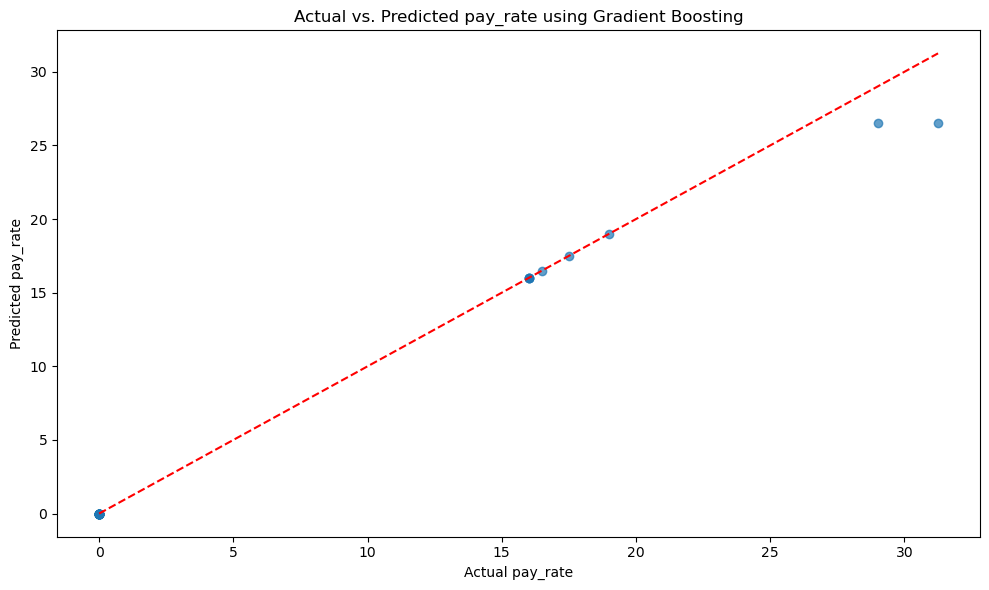

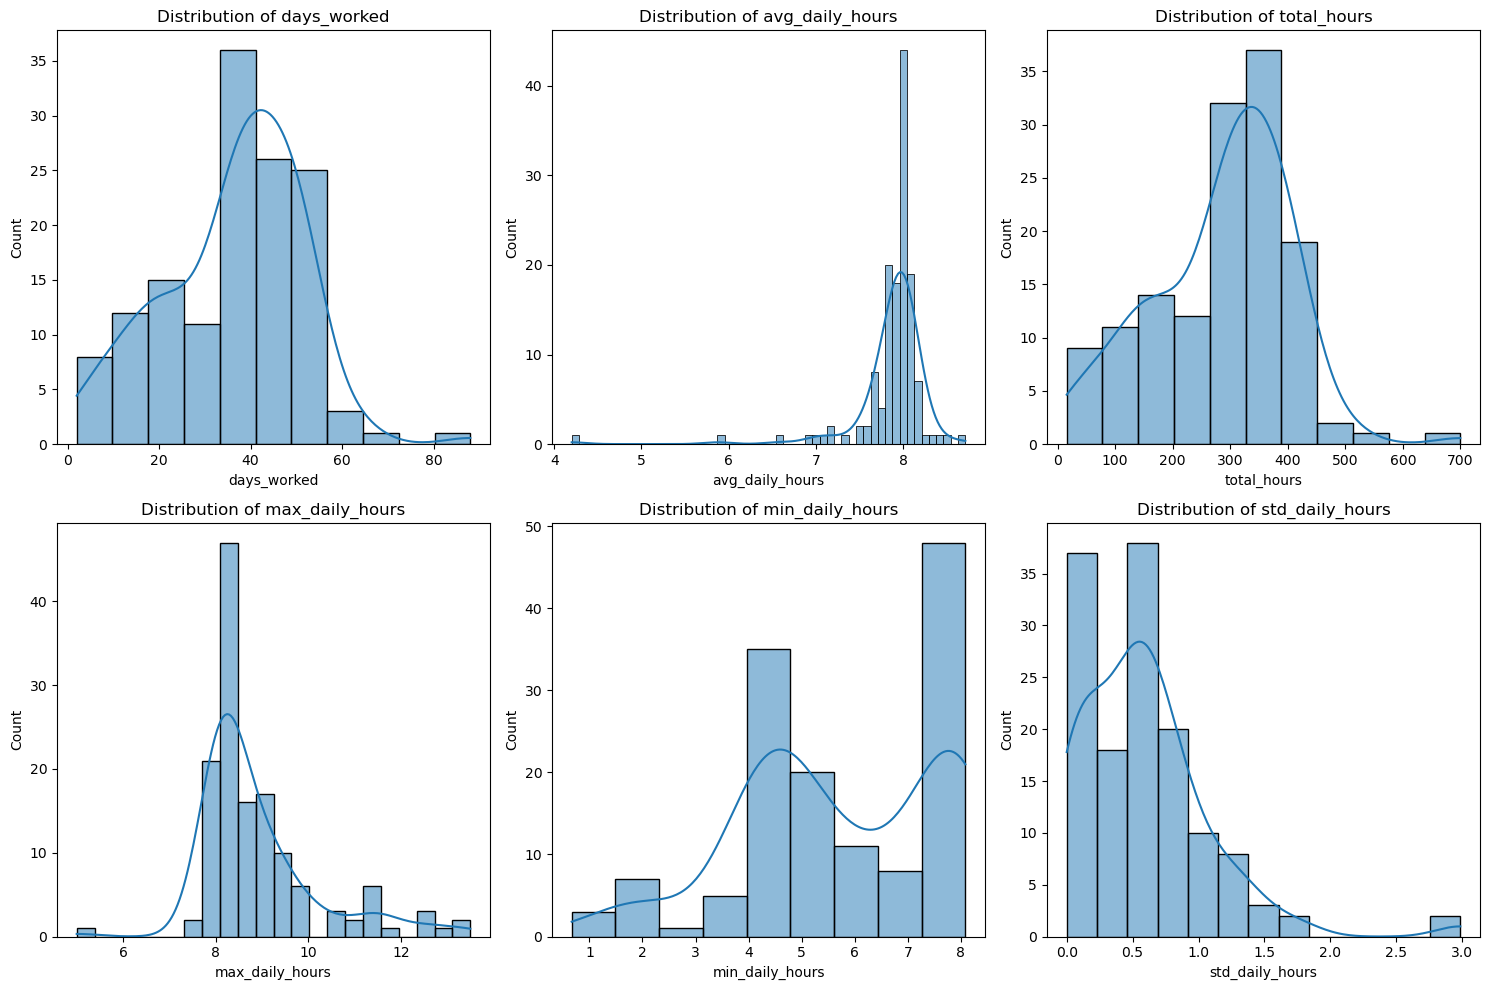

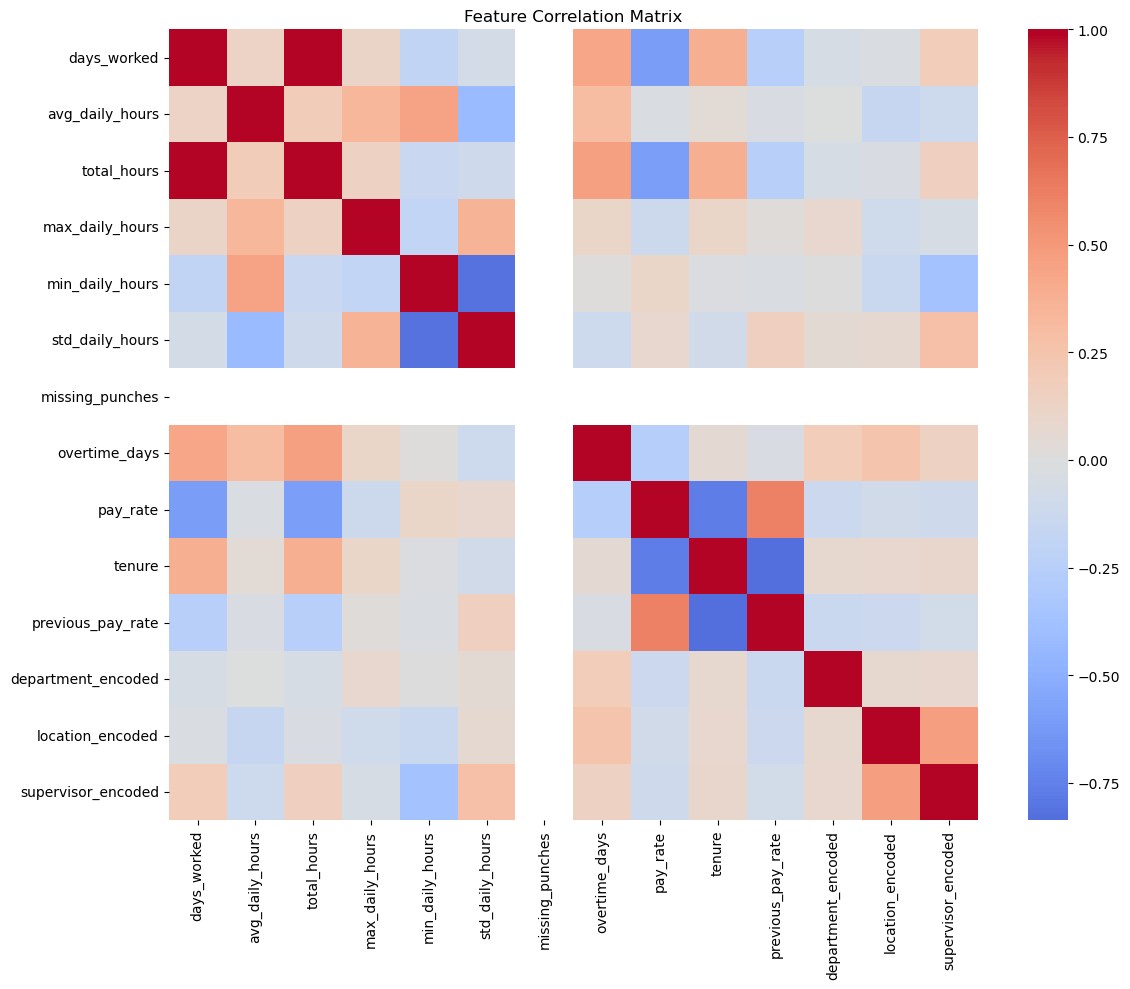

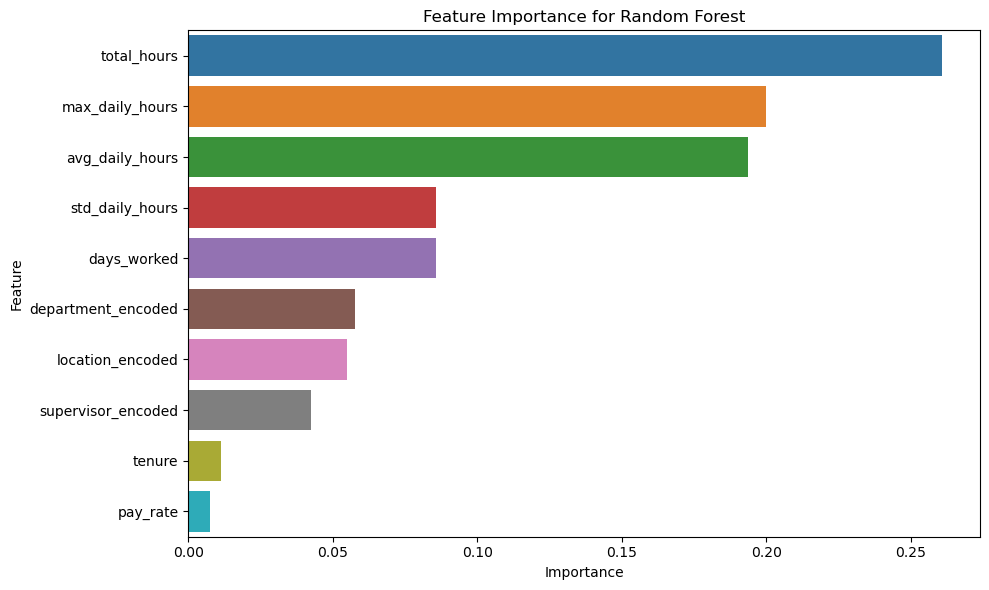

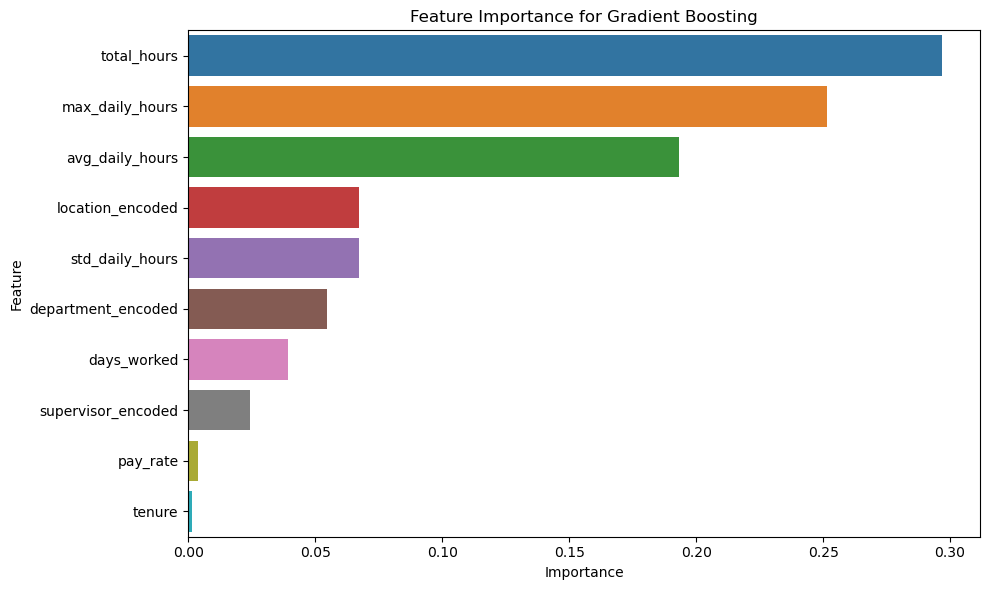

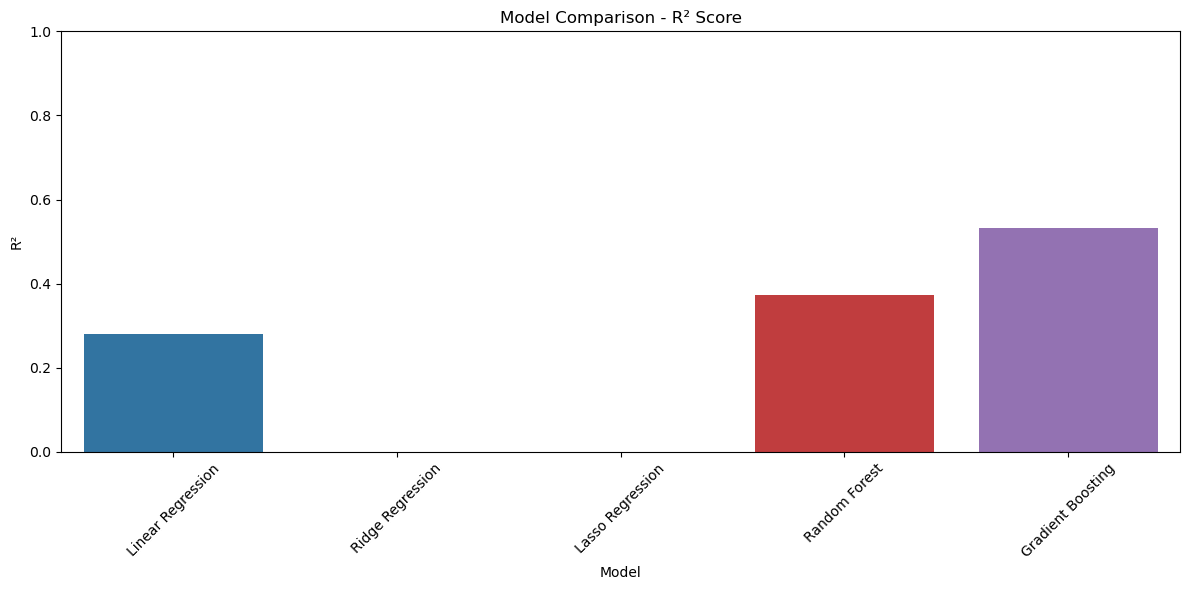

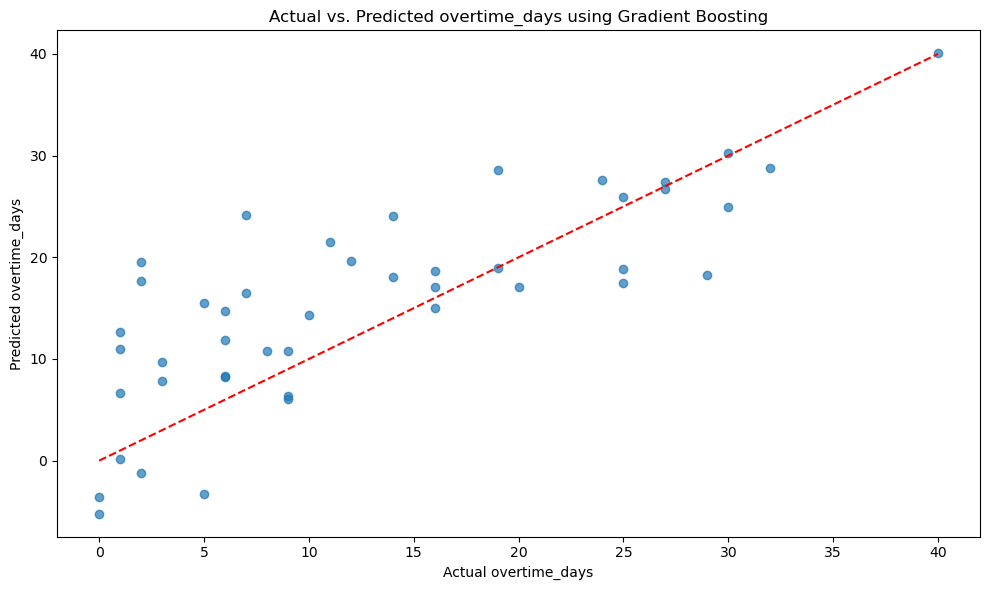

In [2]:
# Main function
def run_ml_pipeline(target_column='pay_rate', k_features=10, time_split=True):
    """Run the complete machine learning pipeline."""
    print(f"Starting ML pipeline for predicting {target_column}")
    
    # Load data
    df = load_data()
    
    # EDA
    numeric_columns = perform_eda(df)
    
    # Select features
    selected_features = select_features(df, target_column, numeric_columns, k=k_features)
    
    # Prepare data
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler = prepare_training_data(
        df, target_column, selected_features, time_split=time_split
    )
    
    # Train and evaluate models
    best_model, results, model_comparison = train_and_evaluate_models(
        X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, selected_features, target_column
    )
    
    # Determine the best model
    best_model_name = model_comparison.sort_values('MAE').iloc[0]['Model']
    print(f"\nBest model: {best_model_name}")
    
    # Fine-tune the best model
    fine_tuned_model = fine_tune_model(
        best_model_name, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled
    )
    
    # Use the fine-tuned model if available
    final_model = fine_tuned_model if fine_tuned_model is not None else results[best_model_name]['model']
    
    # Plot actual vs. predicted
    y_pred = results[best_model_name]['predictions']
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel(f'Actual {target_column}')
    plt.ylabel(f'Predicted {target_column}')
    plt.title(f'Actual vs. Predicted {target_column} using {best_model_name}')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    print("Actual vs. Predicted plot saved to 'actual_vs_predicted.png'")
    
    print("\nML pipeline completed successfully!")
    
    return final_model, scaler, selected_features, df

# Choose targets to predict
if __name__ == "__main__":
    # Run the ML pipeline for different target variables
    print("\n===== PREDICTING PAY RATE =====")
    pay_model, pay_scaler, pay_features, df = run_ml_pipeline(target_column='pay_rate')
    
    print("\n===== PREDICTING OVERTIME DAYS =====")
    overtime_model, overtime_scaler, overtime_features, _ = run_ml_pipeline(target_column='overtime_days')
    
    # Optional: You can add more prediction targets here
    # print("\n===== PREDICTING TOTAL HOURS =====")
    # hours_model, hours_scaler, hours_features, _ = run_ml_pipeline(target_column='total_hours')
    
    print("\nCompleted all machine learning pipelines!")